In [340]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import scienceplots

plt.style.use("science")

In [342]:
d = 101 # Mpc
d = 101 * 10e6 * 3.086*10e16

spectra = pd.DataFrame(
    {
        "photon_energy": [2.36, 2.92, 3.49, 4.08, 4.71, 5.37, 5.96, 6.59, 7.18, 7.75, 8.37, 9.00, 9.59],
        "flux": [3.70e-31, 3.48e-31, 2.94e-31, 2.57e-31, 2.04e-31, 1.87e-31, 1.57e-31, 1.68e-31, 1.46e-31, 1.33e-31, 1.18e-31, 8.89e-32, 7.54e-32]
    }
)

spectra["photon_frequency"] = spectra["photon_energy"] * (1.6e-16) / 6.63e-34
spectra["flux_sigma"] = spectra["flux"] * 0.2
spectra["luminosity"] = 4*np.pi*d**2*spectra["flux"]
spectra["luminosity_sigma"] = (2*spectra["flux_sigma"]/spectra["flux"]) * spectra["luminosity"]

spectra["log_frequency"] = np.log(spectra["photon_frequency"])
spectra["log_luminosity"] = np.log(spectra["luminosity"])
spectra["log_luminosity_sigma"] = spectra["luminosity_sigma"]/spectra["luminosity"]

In [360]:
f_x = lambda x, a, b:a*x + b 

[slope, intercept], _ = curve_fit(
    f_x,
    spectra["photon_frequency"].to_numpy(),
    spectra["log_luminosity"].to_numpy(),
    sigma=spectra["log_luminosity_sigma"].to_numpy()
)

In [365]:
# bootstrap

residuals = spectra["log_luminosity"] - (slope*spectra["photon_frequency"] + intercept)
slopes = []
intercepts = []

for i in range(10000):
    resid = residuals.to_numpy().copy()
    np.random.shuffle(resid)
    
    [slope, intercept], _ = curve_fit(
        f_x,
        spectra["photon_frequency"].to_numpy(),
        spectra["log_luminosity"].to_numpy() + resid,
        sigma=spectra["log_luminosity_sigma"]
    )
    
    slopes.append(slope)
    intercepts.append(intercept)


python(21666) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(21667) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(21668) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


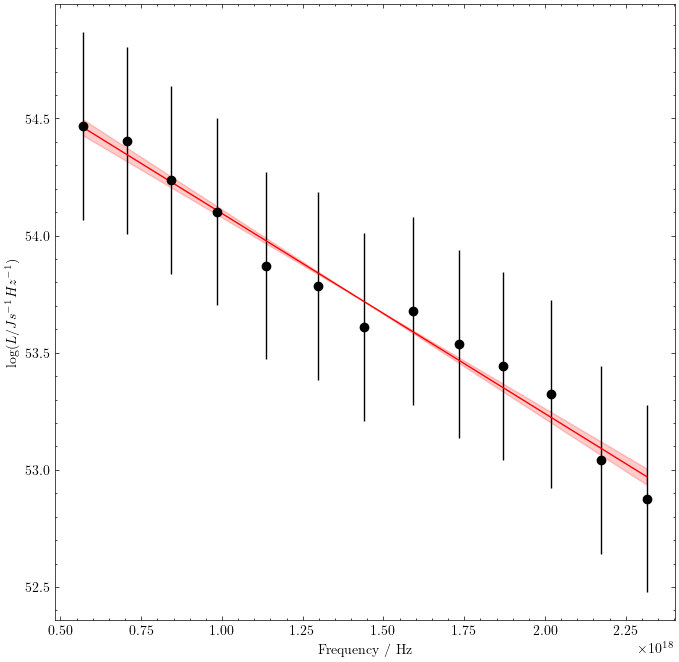

In [431]:
plt.figure(figsize=(8,8))
plt.errorbar(
    spectra["photon_frequency"],
    spectra["log_luminosity"],
    yerr=spectra["log_luminosity_sigma"],
    marker="o",
    ls="none",
    color="black"
)

b = np.mean(slopes)
sigma_b = np.std(slopes)

c = np.mean(intercepts)
sigma_c = np.std(intercepts)

plt.plot(
    spectra["photon_frequency"],
    b*spectra["photon_frequency"] + c,
    color="red"
)

plt.fill_between(spectra["photon_frequency"], 
                (b + sigma_b)*spectra["photon_frequency"] + c - sigma_c , 
                (b - sigma_b)*spectra["photon_frequency"] + c + sigma_c , 
                color="red",
                alpha=0.2)

plt.xlabel("Frequency / Hz")
plt.ylabel(r"$\log(L / J s^{-1} Hz^{-1})$")
plt.savefig("./temperature_plot.png", dpi=300)

In [370]:
h = 6.63*10**-34
k = 1.38*10**-23

T = -h/(k * np.mean(slopes))

T_err1 = T - (-h/(k * (np.mean(slopes) - np.std(slopes))))
T_err2 = T - (-h/(k * (np.mean(slopes) + np.std(slopes))))

print(f"Temperature of the gas: {T} +- ({T_err1, T_err2}) K")

Temperature of the gas: 56227773.999377735 +- ((2482077.321797952, -2722431.3158703297)) K


# Q1) Part B

In [398]:
spectra["volume"] = spectra["luminosity"]/(6.8*10**-51 * (1)**2 * T**-0.5 * 10**3 * 10**3 * 1 * np.exp((-6.63*10**-34*spectra["photon_frequency"])/(1.38*10**-23 * T)))
spectra["volume_sigma"] = spectra["luminosity_sigma"]/(6.8*10**-51 * (1)**2 * T**-0.5 * 10**3 * 10**3 * 1 * np.exp((-6.63*10**-34*spectra["photon_frequency"])/(1.38*10**-23 * T)))

In [417]:
np.sum(spectra["volume"])

1.051082609472736e+73

In [436]:
print(f"The mass of the gas is: {np.sum(spectra['volume'])*(10**3 * 1.66*10**-27)/(2*10**30)} +- {np.sqrt(np.sum(spectra['volume']**2))*(10**3 * 1.66*10**-27)/(2*10**30)}")

The mass of the gas is: 8.723985658623708e+18 +- 2.426334309785342e+18


Q1) Part C

In [326]:
spectra["luminosity"][0]

4.516959318035837e+23

In [327]:
B = (spectra["luminosity"][0] * 3*1.25663*10**-6/(2*6.65*10**-29*3*10**8*1**2*(1/6)**2))**0.5
print(B) 

3.919694605658351e+19


In [329]:
print(B/10**4) 

3919694605658351.0


In [328]:
B/(10**-4*10**9) # Rough magnetar size - https://www.nature.com/articles/nature03525
# https://www.aanda.org/articles/aa/abs/2007/06/aa6163-06/aa6163-06.html

391969460565835.1

Question 2

In [203]:
df = pd.read_csv("./13-May-2005_full_photon_data.csv", sep=" ")
df = df[df["Photon_Flux(ph/s/cm^2/keV)"] != "########"]

df["Energy(keV)"] = df["Energy(keV)"].astype(float)
df["Photon_Flux(ph/s/cm^2/keV)"] = df["Photon_Flux(ph/s/cm^2/keV)"].astype(float)


df = df[(df["Energy(keV)"] > 20)] # & (df["Energy(keV)"] < 150)]

df["spectrum(erg/s/keV)"] = df["Photon_Flux(ph/s/cm^2/keV)"]*10**4*df["Energy(keV)"]*4*np.pi*1.496*10e11*1.6*10**-9

python(21589) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(21590) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(21591) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


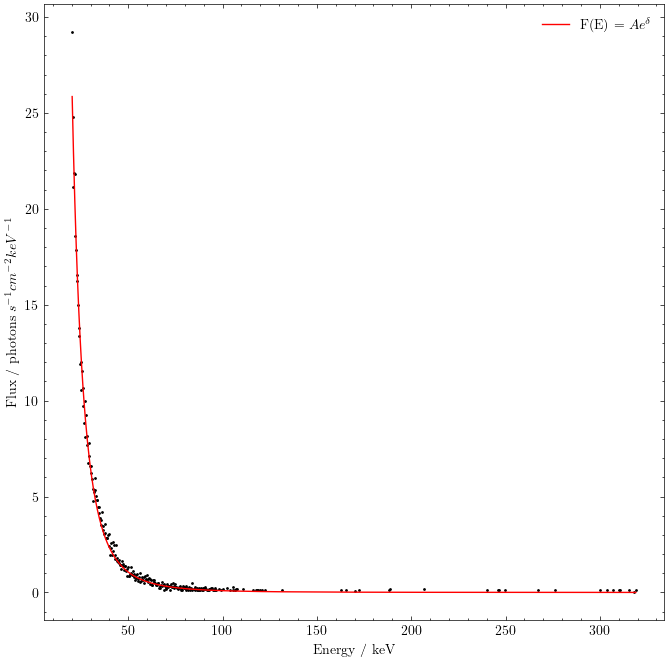

In [426]:
plt.figure(figsize=(8,8))
g_x = lambda E, delta, a: a*E**(-delta)

[delta, a], _ = curve_fit(
    g_x,
    xdata=df["Energy(keV)"],
    ydata=df["Photon_Flux(ph/s/cm^2/keV)"]
)

plt.scatter(
    df["Energy(keV)"],
    df["Photon_Flux(ph/s/cm^2/keV)"],
    s=1,
    color="black"
)

plt.plot(
    df["Energy(keV)"],
    g_x(df["Energy(keV)"], delta, a),
    color="red",
    label=r"F(E) = $Ae^{\delta}$"
)
plt.legend()
plt.xlabel("Energy / keV")
plt.ylabel(r"Flux / photons $s^{-1} cm^{-2} keV^{-1}$")
plt.savefig("./power_law_fit.png", dpi=300)

In [249]:
# Conversion factor

a*10e5*10**4*(4*np.pi*(1.496*10e11)**2)*1.6*10**-9

4.8581781870779784e+32

In [227]:
g_x = lambda E, delta, a: a*E**(-delta)

[delta, a], _ = curve_fit(
    g_x,
    xdata=df["Energy(keV)"],
    ydata=df["spectrum(erg/s/keV)"]/10**11
)

In [437]:
# Electron delta slope
-2.4356290203434234 - 1.5

-3.9356290203434234

In [438]:
delta = a - 1.5

In [ ]:
'''
1 in 10^5 electrons produce a
HXR photon when they reach the
chromosphere; the rest lose their
energy to Coulomb collisions with
(mostly) electrons
'''

#C = (photon_flux at 50keV) * 10^5